## Import Packages

In [37]:
import vaex
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold, train_test_split ,RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Load Data

In [38]:
#This function allows for flexible read of our different temporal spatial combinations
def read_trip_data(temporal_resolution, spatial_resolution, census):
    #Due to our naming we need to differentiate between census and hexagons when doing feature selection
    if census:
        FEATURES = [ "start_month", "start_weekday",f"ts_start_{temporal_resolution}_hour", f"start_{temporal_resolution}_hour",
        "Pickup Census Tract", "demand"]
        file_path_trips = f'data/trips/trips_grouped_{temporal_resolution}h_census.hdf'
    else:
        FEATURES = [ "start_month", "start_weekday",f"ts_start_{temporal_resolution}_hour", f"start_{temporal_resolution}_hour",
        f"pickup_hex_{spatial_resolution}", "demand"]
        file_path_trips = f'data/trips/trips_grouped_{temporal_resolution}h_r{spatial_resolution}.hdf'
    
    file_path_weather = f'data/weather_data_hourly_{temporal_resolution}.pickle'
    
    trips_df = vaex.open(file_path_trips)
    trips_df_pd = trips_df[FEATURES].to_pandas_df()

    if census:
        trips_df_pd["Pickup Census Tract"] = trips_df_pd["Pickup Census Tract"].astype(str)
    weather_df = pd.read_pickle(file_path_weather)
    
    #Here we merge our data with the corresponding weather dataframes
    merged_df = trips_df_pd.merge(weather_df, left_on = f'ts_start_{temporal_resolution}_hour', right_on = 'datetime', how = 'left')
    merged_df = merged_df.drop([f'ts_start_{temporal_resolution}_hour'], axis = 1)

    column_order = [col for col in merged_df.columns if col != 'demand'] + ['demand']
    trips_df_reordered = merged_df[column_order]
    
    return  trips_df_reordered

### Prepare Data

In [39]:
#Encoding of our numerical and categorical variables
def encode_data(dataframe, temporal_resolution, spatial_resolution, census):

    numerical_columns = ['start_month', 'start_weekday', f"start_{temporal_resolution}_hour", 'demand', 'Temperature', 'Humidity',
                         'Wind Speed', 'Precip.', 'cloud', 'rain', 'Fair', 'Fog', 'Snow', 'T-Storm', 'Thunder']

    if census:
      categorical_columns = ['Pickup Census Tract']
    else:
      categorical_columns = [f"pickup_hex_{spatial_resolution}"]

    # Initialize scalers and encoders
    scaler = StandardScaler()
    encoder = OneHotEncoder(drop='first', sparse_output=False)

    # Apply transformations
    transformers = [
        ('numerical', scaler, numerical_columns),
        ('categorical', encoder, categorical_columns)
    ]

    preprocessor = ColumnTransformer(transformers, remainder='passthrough')
    processed_data = preprocessor.fit_transform(dataframe)

    return processed_data


### Create Training and Test Data

In [40]:
#Implementation of valiation strategy to use Training and Test data
def split_data(data_array):
    X = data_array[:, :-1]  # All columns except the last one (demand)
    y = data_array[:, -1]    # Target column 'demand'
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)
    return X_train, X_test, y_train, y_test

### Hyperparameter tuning

- epsilon 
- kernel type: linear, polynomial, RBF
- C: regularization parameter (correctly separate as many instances as possible rather than creating a hyperplane with the largest minimum margin)
- gamma (only for rbf): curvature in a decision boundary

In [41]:
# Common hyperparameters search space
common_hyperparameters = {
    'C': [0.1, 1, 10],          # Regularization parameter
   'epsilon': [0.1, 0.01, 0.001]  # Insensitivity parameter for support vectors
}

# Kernel-specific hyperparameters search space
kernel_hyperparameters = {
    'linear': {},
    'poly': {
        'degree': [2, 3, 4],    # Degree of the polynomial kernel
        'C': [0.1, 1, 10]       # Regularization parameter for the 'poly' kernel
    },
    'rbf': {
        'gamma': ['scale', 'auto', 0.1, 1]  # Kernel coefficient for the 'rbf' kernel
    }
}

#### Perform Grid Search

In [42]:
#Grid Search is essential for finding the most optimal hyperparameters
def find_best_trained_svr(X_train, y_train):

    best_models = {}

    for kernel, params in kernel_hyperparameters.items():
        svr = SVR(kernel=kernel)
        #Here we choose 2-fold cross-validationn to keep computations as small as possible
        grid_search = GridSearchCV(svr, {**common_hyperparameters, **params}, cv=2, n_jobs = -1, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        
        best_models[kernel] = grid_search.best_estimator_

        print('something')

    return best_models
#stores the best-trained SVR models for each kernel type with their optimal hyperparameters

In [ ]:
# def hyp_cross_validation(X_train, y_train, kernel_hyperparameters):
#     cross_val_scores = {}

#     for kernel, params in kernel_hyperparameters.items():
#         svr = SVR(kernel=kernel, **params)
#         scores = cross_val_score(svr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
#         mean_score = -scores.mean()  # Convert negative MSE back to positive
#         cross_val_scores[kernel] = mean_score

#     print(cross_val_scores)

In [43]:
#This method can optionally be used to randomly do grid search instead of comparing every parameter
def find_best_trained_svr_random(X_train, y_train):
    best_models_random = {}

    for kernel, params in kernel_hyperparameters.items():
        svr = SVR(kernel=kernel)
        random_search = RandomizedSearchCV(svr, {**common_hyperparameters, **params}, n_iter=5, cv=2)
        random_search.fit(X_train, y_train)
        
        best_models_random[kernel] = random_search.best_estimator_

    return best_models_random

### Evaluate Model

In [44]:
#This function calculates the goodness of our models by introducing MSE, MAE and R2 value
def evaluation(X_test, y_test, best_models):

    evaluation_results = {}

    for kernel, model in best_models.items():
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        evaluation_results[kernel] = {'MSE': mse, 'MAE': mae, 'R2': r2}

    return evaluation_results


### Plots

In [45]:
def compare_kernel_performance(evaluation_results):
    # List of kernel types and their corresponding evaluation results
    kernel_types = list(evaluation_results.keys())
    evaluation_results = {
        'MSE': [result['MSE'] for result in evaluation_results.values()],
        'MAE': [result['MAE'] for result in evaluation_results.values()],
        'R2': [result['R2'] for result in evaluation_results.values()]
    }

    # Create bar plots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    for i, metric in enumerate(['MSE', 'MAE', 'R2']):
        ax = axes[i]
        ax.bar(kernel_types, evaluation_results[metric])
        ax.set_title(metric)
        ax.set_ylabel(metric)

    plt.tight_layout()
    plt.show()


#### Create Final Dataset

In [46]:
def create_final_output(X_test, initial_df, y_test, y_pred):
    # Create an output dataframe with original data and predicted demand
    output_df = pd.DataFrame(X_test, columns=initial_df.feature_names)
    output_df['actual_demand'] = y_test
    output_df['predicted_demand'] = y_pred

    print(output_df.head())

### Create Pipeline

In [47]:
#Here we put our different functions together to run the pipeline for different temporal spatial combinations
def pipeline(temporal_resolution, spatial_resolution, census):

    data_list = []   
   
    trips_prepared = read_trip_data(temporal_resolution, spatial_resolution, census)

    trips_encoded = encode_data(trips_prepared, temporal_resolution, spatial_resolution, census)

    X_train, X_test, y_train, y_test = split_data(trips_encoded)

    optimal_models_grid = find_best_trained_svr(X_train, y_train)

    # Create a new SVR model with the best hyperparameters
    #best_model = SVR(**best_params)
    # Fit the new model using the training data
    #best_model.fit(X_train, y_train)
    # Use the newly fitted model to make predictions
    #with open(model_path, "wb") as file:
    #    pickle.dump(best_model, file)

    #hyp_cross_validation(X_train, y_train, optimal_models_grid)

    evaluation_score = evaluation(X_test, y_test, optimal_models_grid)

    for kernel_type, results in evaluation_score.items():
            mse = results['MSE']
            mae = results['MAE']
            r2 = results['R2']
            
            data = {
                'Spatial_Resolution': spatial_resolution,
                'Temporal_Resolution': temporal_resolution,
                'Kernel_Type': kernel_type,
                'MSE': mse,
                'MAE': mae,
                'R2': r2
            }
            data_list.append(data)

    # Create a pandas DataFrame from the list of dictionaries
    results_df = pd.DataFrame(data_list)
    results_df.to_csv(f'../AAA_2023/data/svm_predictions/results_{temporal_resolution}h_{spatial_resolution}')
    
    compare_kernel_performance(evaluation_score)
    

### Load of Model Performance

Due to the costly and time-consuming predictions, the Notebooks were executed in parallel using google colab pro and the performances where saved as csv. files. In the following we will read in the different performances and combine them into a single dataframe for analysis

In [53]:
folder_path = 'data/svm_predictions/'
results_df = pd.DataFrame()

# List all CSV files in the folder
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# Loop through each CSV file and concatenate them
for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    df = pd.read_csv(file_path)
    results_df = pd.concat([results_df, df], ignore_index=True)



In [54]:
results_df = results_df.drop(['Parameters', 'Unnamed: 0'], axis = 1)

In [56]:
sorted_df = results_df.sort_values(by='Spatial_Resolution', ascending=True)
sorted_df

,Spatial_Resolution,Temporal_Resolution,Kernel_Type,MSE,MAE,R2
0,5,1,linear,0.016425,0.023897,0.840266
2,5,4,linear,0.043715,0.115592,0.585549
3,5,4,poly,0.046427,0.053364,0.559840
4,5,4,rbf,0.017394,0.053685,0.835092
6,5,6,linear,0.053845,0.126937,0.456222
7,5,6,poly,0.057479,0.163506,0.419521
8,5,6,rbf,0.017617,0.063430,0.822088
5,6,4,linear,0.015419,0.023571,0.613632
1,7,24,rbf,0.001091,0.026924,0.747978


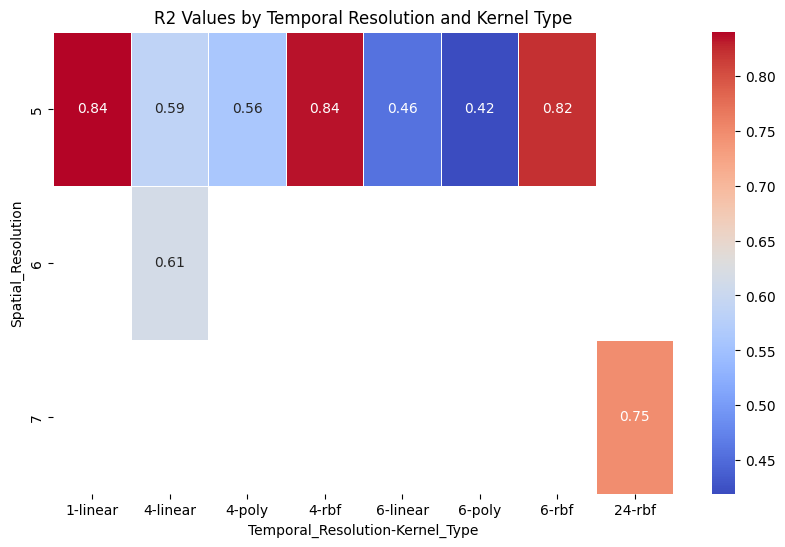

In [57]:
# Create a pivot table for better visualization
pivot_table = sorted_df.pivot_table(index='Spatial_Resolution', columns=['Temporal_Resolution', 'Kernel_Type'], values='R2')

# Set up the plot
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('R2 Values by Temporal Resolution and Kernel Type')
plt.show()

The Figure shows the R2 values for different spatial resolutions, tempral resolutions and kernel types. It can be seen that for a low temporal resolution of 1h the linear kernel produces quite a good R2 value for the resolution of 5. If we go up for our spatial resolution to 4 and 6, the performance of the linear kernel decreased by a large number, while RBF kernel yields quite good results. It can also be observed, that performance for the linear kernel increases with a higher spatial resolution. We can also observe that for 24h resolution the rbf kernel yields a decent value of 0.75 for a resolution of 7 seeing that our predictions get worse for larger sizes of resolutions. Due to the very time-consuming predictions, we were only able to test a view variances and not go through all models

### Improvements

Futher improvements in a follow-up project could be to use less categorical variables. Hex_id was encoded with target encoding, so another approach could be to transform hex values back to continuous variables instead of using target encoding.  

In [ ]:
#transform hex to numerical
### df['lat'] = df['pickup_hex'].apply(lambda x: h3.cell_to_latlng(x)[0])
### df['long'] = df['pickup_hex'].apply(lambda x: h3.cell_to_latlng(x)[1])
### df = df.drop(['hex', 'pickup_hex_7'], axis=1)

Another approach could be to build another nested loop that creates SVR for multiple Hexagons, by splitting the data to individual hexagon datasets. With this approach, 'real' spatio-temporal forecasting is possible. For example the resolution of 5 created 9 hexagons that would result in 9 SVM predicting the target variable. 

Also, POI data can be used to create further hexagon related features, e.g. the density of restaurants and bars per hexagon that we calculated in the descriptive part.  

As seen in the data description part, some extreme target variable values exist, so scaling the target variable or excluding outliers could achieve better results for SVR. Therefore we could use the transformed target regressor. 

In [ ]:
### regressor = SVR(kernel='linear')
### transformed_regressor = TransformedTargetRegressor(regressor=regressor,
                                                  ###   func=scaler,
                                                  ###   inverse_func=inverse_scaler)
### transformed_regressor.fit(X_train, y_train)

Lastly, we could use cross-validation and test more model parameters in grid search. For now we decided to choose two initial values for each parameter to get a first 'trend', because of the runtime. 